## Gradient Checkpointing Model-Agnostic Meta-Learning

We demonstrate how to use memory efficient MAML on CIFAR10.
This notebook performs one forward and backward for MAML with a large number of iterations

* Data: Random tensors (batch_size, 3, 224, 224)  
* Model: ResNet18
* Optimizer: SGD with 0.01 learning rate
* Batch size: 16
* MAML steps: 100 (works with >500 on 11GB GPU)
* GPU: whatever colab has to spare, probably K80

In [1]:
%env CUDA_VISIBLE_DEVICES=0
# colab dependencies
!pip install torch==1.3.1 torchvision==0.4.2 torch_maml

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import torch_maml

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# For reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmarks = False

env: CUDA_VISIBLE_DEVICES=0
     |████████████████████████████████| 734.6 MB 15 kB/s 
     |████████████████████████████████| 10.2 MB 8.6 MB/s 
  Created wheel for torch-maml: filename=torch_maml-1.0-py3-none-any.whl size=9392 sha256=7d5f0dd144e89d9cad9ae7bb4f9138e80f9f981943001ed2a6a758ecaa5bb5b3
  Stored in directory: /root/.cache/pip/wheels/6d/99/30/1894147ba887f41ae4b4d39ff75584b2c5fa016f35a22eeca8
Successfully built torch-maml
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires t

#### Define compute_loss function and create model

In [2]:
# Interface:
# def compute_loss(model, data, **kwargs):
#      <YOUR CODE HERE>  # ideally this should be stateless (does not change global variables)
#      return loss

# Our example
def compute_loss(model, data, device='cuda'):
    inputs, targets = data
    preds = model(inputs.to(device=device))
    loss = F.cross_entropy(preds, targets.to(device=device))
    return loss

In [3]:
# Model is a torch.nn.Module 
model = models.resnet18(num_classes=10).to(device)
# Optimizer is a custom MAML optimizer, e.g. SGD
optimizer = torch_maml.IngraphGradientDescent(learning_rate=0.01)

#### Create NaiveMAML and GradientCheckpointMAML for comparison

In [4]:
efficient_maml = torch_maml.GradientCheckpointMAML(
    model, compute_loss, optimizer=optimizer, checkpoint_steps=5)

naive_maml = torch_maml.NaiveMAML(model, compute_loss, optimizer=optimizer)

#### Sanity check: small number of steps

Both naive and memory-efficient maml should produce the same output.

In [5]:
# First, we set such max steps that fits memory for naive MAML to check the implementation
maml_steps = 10

# Clip meta-learning gradients by global norm to avoid explosion
max_grad_grad_norm = 1e2

In [6]:
# Generate batch for demonstration. Note that we support using different batches for each MAML step (a-la SGD)
x_batch, y_batch = torch.randn((16, 3, 224, 224)), torch.randint(0, 10, (16, ))
inputs = [(x_batch, y_batch)] * maml_steps  # use the same batch for each step

In [7]:
updated_model, loss_history, _ = naive_maml(inputs, loss_kwargs={'device':device},
                                            max_grad_grad_norm=max_grad_grad_norm)
final_loss = compute_loss(updated_model, (x_batch, y_batch), device=device)
final_loss.backward()
grads_naive = [params.grad for params in model.parameters()]
print("Loss naive: %.4f" % final_loss.item())

Loss naive: 0.5537


In [8]:
updated_model, loss_history, _ = efficient_maml(inputs, loss_kwargs={'device':device},
                                                max_grad_grad_norm=max_grad_grad_norm)
final_loss = compute_loss(updated_model, (x_batch, y_batch), device=device)
final_loss.backward()
grads_efficient = [params.grad for params in model.parameters()]
print("Loss memory-efficient: %.4f" % final_loss.item())

Loss memory-efficient: 0.5537


In [9]:
for grad1, grad2 in zip(grads_naive, grads_efficient):
    assert torch.allclose(grad1, grad2)

print("All grads match!")

All grads match!


In [10]:
# alternative: use rmsprop optimizer
rmsprop_maml = torch_maml.GradientCheckpointMAML(
    model, compute_loss, optimizer=torch_maml.IngraphRMSProp(learning_rate=1e-3, beta=0.9, epsilon=1e-5), 
    checkpoint_steps=5)

updated_model, loss_history, _ = rmsprop_maml(inputs, loss_kwargs={'device':device},
                                                max_grad_grad_norm=max_grad_grad_norm)
final_loss = compute_loss(updated_model, (x_batch, y_batch), device=device)
final_loss.backward()
grads_efficient = [params.grad for params in model.parameters()]
print("Loss RMSProp: %.4f" % final_loss.item())

Loss RMSProp: 0.0224


### The real meta-learning: 100 steps and beyond

In [11]:
maml_steps = 100  # feel free to tweak (works with >500)
inputs = [(x_batch, y_batch)] * maml_steps
torch.cuda.empty_cache()

Loss memory-efficient: 0.0427


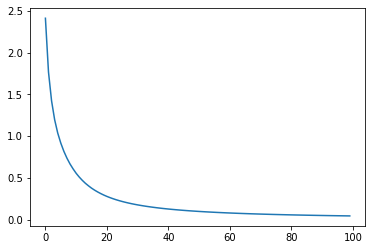

In [12]:
updated_model, loss_history, _ = efficient_maml(inputs, loss_kwargs={'device':device},
                                        max_grad_grad_norm=max_grad_grad_norm)
final_loss = compute_loss(updated_model, (x_batch, y_batch), device=device)
final_loss.backward()
grads_efficient = [params.grad for params in model.parameters()]

plt.plot(loss_history)
print("Loss memory-efficient: %.4f" % final_loss.item())